<a href="https://colab.research.google.com/github/jongheon1/node-express/blob/main/ML_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cifar-10 데이터셋을 학습시켜 새와 비행기를 구분하도록 하겠습니다.

In [ ]:
import torch
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print(f"Using {device} device")

Using cuda device


gpu에서 돌아가도록 해 줍니다.

In [ ]:
from torchvision import datasets, transforms
import torch; torch.manual_seed(0)
from torch import optim
import torch.nn as nn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



data_path = '../data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=ToTensor()
)
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


cifar-10 데이터를 다운 받습니다. 훈련셋과 검증셋을 구분해서 다운받았습니다.


cifar10은 자동으로 torch.utils.data.Dataset의 서브 클래스로 반환되기 때문에 따로 클래스를 만들어서 지정해 주지 않아도 됩니다. 

하지만 굳이 torch.utils.data.Dataset의 서브 클래스일 필요도 없습니다. 왜냐면 데이터셋은 작고, 인덱싱과 len만 있으면 되기 때문입니다.

In [ ]:
label_map={0:0,2:1} #비행기는 cifar에서 0, 새는 cifar에서 2인데 이것을 각각 0 그리고 1로 바꾸어 줍니다.
class_names = ['airplane', 'bird']
cifar = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

cifar10에 있는 데이터를 새와 비행기의 사진만 필터링하고 다시 매핑해서 새로운 데이터셋을 만들었습니다.

이제 데이터를 넣을 모델이 필요합니다. 몇가지 모델을 이용해 학습시키고 성공률을 비교해보겠습니다.

In [ ]:
n_out = 2
model = nn.Sequential(
    nn.Linear(
        3072, #입력 피처, 이미지가 32*32*3인데 이를 1차원 벡터로 늘어뜨렸기 때문에 3072개의 입력 피처를 만들었습니다.
        512, #임의로 512개의 은닉된 피처를 골랐습니다.
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out,
    ),
    nn.Softmax(dim=1) #softmax = torch.exp(x)/torch.exp(x).sum()
)

훈련 시키기 전 가장 기본적인 모델을 만들어보았습니다. softmax를 통해 수를 0과 1 사이로 바꾸어주었습니다.

여기서 출력값은 카테고리입니다. 이상적인 경우 신경망은 비행기에 대해 torch.tensor([1.0,0.0])을 출력하고 새에 대해선 반대로 출력해야합니다.

tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward0>)


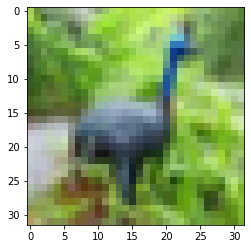

In [ ]:
img,_ = cifar[0]
img_batch = img.view(-1).unsqueeze(0)
print(model(img_batch))
plt.imshow(img.permute(1,2,0))
plt.show()

훈련 시키기 전 이미지입니다. 

출력이 확률의 형태로 나왔고 우연히 새를 의미하는 것이 나오긴 했지만 

무작위로 초기화한 값이기 때문에 현재로선 아무런 의미가 없습니다.

이제 모델에 이미지를 넣고 돌려서 훈련을 시킬 것입니다.

먼저 NLL함수를 이용한 것입니다.

learning rate는 1e-2이고

optimizer는 SGD이고

loss function은 NLLloss를 이용했습니다.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64,
                                           shuffle=True)
model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 20

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.674485
Epoch: 1, Loss: 0.617265
Epoch: 2, Loss: 0.780723
Epoch: 3, Loss: 0.559616
Epoch: 4, Loss: 0.420487
Epoch: 5, Loss: 0.587275
Epoch: 6, Loss: 0.233775
Epoch: 7, Loss: 0.375139
Epoch: 8, Loss: 0.313992
Epoch: 9, Loss: 0.592614
Epoch: 10, Loss: 0.347440
Epoch: 11, Loss: 0.418935
Epoch: 12, Loss: 0.378459
Epoch: 13, Loss: 0.474048
Epoch: 14, Loss: 0.397035
Epoch: 15, Loss: 0.293082
Epoch: 16, Loss: 0.380939
Epoch: 17, Loss: 0.409839
Epoch: 18, Loss: 0.221208
Epoch: 19, Loss: 0.836794


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))


Accuracy: 0.755100


다음으론 다른건 위와 같이만 모델에 계층을 더 추가하였습니다

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64,
                                           shuffle=True)
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 20

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.596481
Epoch: 1, Loss: 0.397408
Epoch: 2, Loss: 0.374668
Epoch: 3, Loss: 0.506387
Epoch: 4, Loss: 0.339134
Epoch: 5, Loss: 0.270393
Epoch: 6, Loss: 0.468351
Epoch: 7, Loss: 0.519288
Epoch: 8, Loss: 0.486565
Epoch: 9, Loss: 0.724310
Epoch: 10, Loss: 0.463287
Epoch: 11, Loss: 0.443597
Epoch: 12, Loss: 0.685252
Epoch: 13, Loss: 0.316082
Epoch: 14, Loss: 0.483777
Epoch: 15, Loss: 0.421172
Epoch: 16, Loss: 0.540434
Epoch: 17, Loss: 0.458017
Epoch: 18, Loss: 0.497861
Epoch: 19, Loss: 0.520904


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))


Accuracy: 0.702900


마지막으로 loss function 으로 cross entropy loss 를 사용한 것입니다.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 20

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.554711
Epoch: 1, Loss: 0.530514
Epoch: 2, Loss: 0.332666
Epoch: 3, Loss: 0.442523
Epoch: 4, Loss: 0.653080
Epoch: 5, Loss: 0.332337
Epoch: 6, Loss: 0.435411
Epoch: 7, Loss: 0.496748
Epoch: 8, Loss: 0.297147
Epoch: 9, Loss: 0.427052
Epoch: 10, Loss: 0.856349
Epoch: 11, Loss: 0.430014
Epoch: 12, Loss: 0.495227
Epoch: 13, Loss: 0.672488
Epoch: 14, Loss: 0.575489
Epoch: 15, Loss: 0.432062
Epoch: 16, Loss: 0.416063
Epoch: 17, Loss: 0.406488
Epoch: 18, Loss: 0.448870
Epoch: 19, Loss: 0.530214


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.680000


비교 결과 가장 처음 NLL을 이용한 것이 정확도가 가장 높게 나왔습니다.

In [ ]:
sum([p.numel() for p in model.parameters()])


3737474

모델의 파라미터 개수가 무려 370만개가 넘습니다.

 이는 예측 가능한 것인데 먼저 x의 길이가 3072였고 1024개의 출력 피쳐를 만들었기 때문입니다.

선형 계층이 y= weight*x+bias라면 3072*1024만 해도 300만이 넘습니다.

---

